<a href="https://colab.research.google.com/github/mahshadmoradi/Machine-Learning/blob/main/project_2nd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.models import resnet18
from torch.utils.data import DataLoader, random_split, Subset, TensorDataset
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, roc_auc_score
import numpy as np
from tqdm import tqdm
import torchvision.models as models
from torchvision.models import ResNet18_Weights
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


The transforms here are considered as they are because Resnet18 from torchvision.models is an ImageNet implementation. Because ImageNet samples much bigger(224x224) than CIFAR10/100 (32x32), the first layers designed to aggressively downsample the input ('stem Network'). It's lead to missing much valuable information on small CIFAR10/100 images. Therefore I upsample it in transformation for better results.

In [2]:
# Define the dataset and data loaders
transform_train = transforms.Compose([
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Resize to 224x224 with random crop
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    # transforms.Resize(256),  # Resize the shorter side to 256 pixels
    # transforms.CenterCrop(224),  # Crop the center 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

100%|██████████| 170498071/170498071 [00:12<00:00, 13277313.54it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


## Modified ResNet18 model

In [3]:
class ModifiedResNet18(nn.Module):
    def __init__(self):
        super(ModifiedResNet18, self).__init__()
        # Load the ResNet18 model with the updated way to specify pretrained weights
        self.resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, 10)  # to match CIFAR-10 classes

    def forward(self, x):
        return self.resnet(x)

In [4]:
def train_on_slice(model, dataloader, epochs, criterion, optimizer):
    model.train()
    for epoch in range(epochs):
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

In [5]:
def shard_and_slice_dataset(dataset, S, R):
    shard_size = len(dataset) // S
    shards = random_split(dataset, [shard_size] * S)
    sliced_shards = []

    for shard in shards:
        slice_size = len(shard) // R
        slices = random_split(shard, [slice_size] * R)
        sliced_shards.append(slices)

    return sliced_shards


def train_models(S, R, epochs):
    sliced_shards = shard_and_slice_dataset(train_dataset, S, R)
    final_models = []

    for shard_id, shard in enumerate(sliced_shards):
        accumulated_dataset = None
        model = ModifiedResNet18().to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=35e-5)

        for slice_id, data_slice in enumerate(shard):
            if accumulated_dataset is None:
                accumulated_dataset = data_slice
            else:
                accumulated_dataset = torch.utils.data.ConcatDataset([accumulated_dataset, data_slice])

            dataloader = DataLoader(accumulated_dataset, batch_size=256, shuffle=True)
            print(f"Training Shard {shard_id+1}, Slice {slice_id+1}")
            train_on_slice(model, dataloader, epochs, criterion, optimizer)

            final_models.append(model.state_dict())

    return final_models

In [6]:
def majority_voting(models, dataloader):
    all_outputs = []

    for model_dict in models:
        model = ModifiedResNet18().to(device)
        model.load_state_dict(model_dict)
        model.eval()

        outputs = []
        with torch.no_grad():
            for inputs, _ in dataloader:
                inputs = inputs.to(device)
                output = model(inputs)
                outputs.append(F.softmax(output, dim=1).cpu().numpy())

        all_outputs.append(np.vstack(outputs))

    # Stack all the outputs from different models
    all_outputs = np.array(all_outputs)

    # Sum the probabilities across all models
    summed_outputs = np.sum(all_outputs, axis=0)

    # Normalize to ensure they sum to 1
    final_outputs = summed_outputs / np.sum(summed_outputs, axis=1, keepdims=True)

    # Calculate the final predictions
    final_preds = final_outputs.argmax(axis=1)

    return final_preds, final_outputs

In [7]:
def adaptive_aggregation(models, dataloader):
    all_outputs = []
    for model_dict in models:
        model = ModifiedResNet18().to(device)
        model.load_state_dict(model_dict)
        model.eval()
        outputs = []
        with torch.no_grad():
            for inputs, _ in dataloader:
                inputs = inputs.to(device)
                output = model(inputs)
                outputs.append(F.softmax(output, dim=1).cpu().numpy())
        all_outputs.append(np.vstack(outputs))

    all_outputs = np.array(all_outputs)
    # Calculate norms for each model's outputs
    norms = np.linalg.norm(all_outputs, axis=(1, 2), keepdims=True)
    # Calculate weights
    weights = 1 / (norms + 1e-10)
    weights /= weights.sum(axis=0, keepdims=True)

    # Apply weights to outputs
    final_outputs = (all_outputs * weights).sum(axis=0)
    final_preds = final_outputs.argmax(axis=1)
    return final_preds, final_outputs

In [8]:
def hierarchical_aggregation(models, dataloader):
    all_outputs = []
    for model_dict in models:
        model = ModifiedResNet18().to(device)
        model.load_state_dict(model_dict)
        model.eval()
        outputs = []
        with torch.no_grad():
            for inputs, _ in dataloader:
                inputs = inputs.to(device)
                output = model(inputs)
                outputs.append(torch.softmax(output, dim=1).cpu().numpy())
        all_outputs.append(np.vstack(outputs))

    final_outputs = np.mean(all_outputs, axis=0)
    final_preds = final_outputs.argmax(axis=1)
    return final_preds, final_outputs

In [9]:
def evaluate_model(predictions, true_labels, probabilities):
    f1 = f1_score(true_labels, predictions, average='macro')
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions, average='macro', zero_division=0)
    recall = recall_score(true_labels, predictions, average='macro')
    auroc = roc_auc_score(true_labels, probabilities, multi_class='ovr')

    return {
        'F1 Score': f1,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'AUROC': auroc
    }

def test_models(models, aggregation_methods, dataloader):
    all_results = {}

    for method_name, method in aggregation_methods.items():
        print(f"Evaluating using {method_name}")
        preds, probs = method(models, dataloader)
        true_labels = np.concatenate([labels.numpy() for _, labels in dataloader])
        results = evaluate_model(preds, true_labels, probs)
        all_results[method_name] = results

    return all_results

In [10]:
# Parameters
S_values = [5, 10, 20]
R_values = [5, 10, 20]
epochs = 10

# Aggregation methods
aggregation_methods = {
    'Majority Voting': majority_voting,
    'Adaptive Aggregation': adaptive_aggregation,
    'Hierarchical Aggregation': hierarchical_aggregation
}

def train_and_test(S, R, epochs):
    print(f"Training with S={S}, R={R}")
    all_models = train_models(S, R, epochs)
    test_loader = DataLoader(test_dataset, batch_size=256, shuffle=False)
    results = test_models(all_models, aggregation_methods, test_loader)
    print(f"\nResults for S={S}, R={R}: {results}")

##Part 2

In [11]:
def select_data_to_forget(dataset, num_forget):
    indices = np.random.choice(len(dataset), num_forget, replace=False)
#     indices = np.arange(num_forget)

#     # Generate a list of all indices in the dataset
#     all_indices = list(range(len(dataset)))

#     # Randomly select 'num_forget' indices to forget
#     indices = random.sample(all_indices, num_forget)

    forget_set = Subset(dataset, indices)
    return indices, forget_set

In [12]:
def identify_shards_containing_data(sliced_shards, forget_indices):
    shards_to_retrain = set()
    total_indices = np.arange(len(train_dataset))

    shard_size = len(train_dataset) // len(sliced_shards)

    for shard_id, shard_slices in enumerate(sliced_shards):
        start_idx = shard_id * shard_size
        end_idx = start_idx + shard_size
        shard_indices_global = total_indices[start_idx:end_idx]

        for slice_id, data_slice in enumerate(shard_slices):
            slice_start_idx = start_idx + slice_id * (shard_size // len(shard_slices))
            slice_end_idx = slice_start_idx + (shard_size // len(shard_slices))
            slice_indices_global = total_indices[slice_start_idx:slice_end_idx]

            if set(slice_indices_global).intersection(forget_indices):
                shards_to_retrain.add(shard_id)
                break

    return shards_to_retrain

In [13]:
def evaluate_on_set(models, forget_set, aggregation_methods):
    forget_loader = DataLoader(forget_set, batch_size=256, shuffle=False)
    results = test_models(models, aggregation_methods, forget_loader)
    return results

In [ ]:
# def unlearn_models(S, R, epochs, device, forget_indices, initial_models):
#     original_sliced_shards = shard_and_slice_dataset(train_dataset, S, R)
#     shards_to_retrain = identify_shards_containing_data(original_sliced_shards, forget_indices)
#     final_models = []

#     for shard_id, shard in enumerate(original_sliced_shards):
#         if shard_id not in shards_to_retrain:
#             final_models.append(initial_models[shard_id])
#             continue

#         # Collect all indices in the shard
#         shard_indices = []
#         for slice_ in shard:
#             shard_indices.extend(slice_.indices)

#         # Remove the forget indices from the shard
#         updated_shard_indices = [idx for idx in shard_indices if idx not in forget_indices]
#         updated_shard = torch.utils.data.Subset(train_dataset, updated_shard_indices)

#         # Slice the updated shard
#         slice_size = len(updated_shard) // R
#         if len(updated_shard) % R != 0:
#             slice_sizes = [slice_size + 1 if i < len(updated_shard) % R else slice_size for i in range(R)]
#         else:
#             slice_sizes = [slice_size] * R
#         updated_slices = random_split(updated_shard, slice_sizes)

#         # Retrain the shard incrementally on its slices
#         accumulated_dataset = None
#         model = ModifiedResNet18().to(device)
#         criterion = nn.CrossEntropyLoss()
#         optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=35e-5)

#         for slice_id, data_slice in enumerate(updated_slices):
#             if accumulated_dataset is None:
#                 accumulated_dataset = data_slice
#             else:
#                 accumulated_dataset = torch.utils.data.ConcatDataset([accumulated_dataset, data_slice])

#             dataloader = DataLoader(accumulated_dataset, batch_size=256, shuffle=True)
#             print(f"Retraining Shard {shard_id+1}, Slice {slice_id+1}")
#             train_on_slice(model, dataloader, epochs*2, criterion, optimizer, device)

#         final_models.append(model.state_dict())

#     return final_models

In [ ]:
# def unlearn_models(S, R, epochs, device, forget_indices, initial_models):
#     original_sliced_shards = shard_and_slice_dataset(train_dataset, S, R)
#     shards_to_retrain = identify_shards_containing_data(original_sliced_shards, forget_indices)
#     final_models = []

#     slice_count_per_shard = len(original_sliced_shards[0])  # Assuming all shards have equal slices

#     for shard_id, shard in enumerate(original_sliced_shards):
#         if shard_id not in shards_to_retrain:
#             final_models.append(initial_models[(shard_id + 1) * slice_count_per_shard - 1])
#             continue

#         # Identify the last slice in the shard that does not contain forget data
#         last_valid_slice_id = None
#         shard_indices = []
#         for slice_id, data_slice in enumerate(shard):
#             shard_indices.extend(data_slice.indices)
#             if not set(data_slice.indices).intersection(forget_indices):
#                 last_valid_slice_id = slice_id

#         # Initialize or use the model from the last valid slice that does not contain forget data
#         model = ModifiedResNet18().to(device)
#         if last_valid_slice_id is not None:
#             model.load_state_dict(initial_models[shard_id * slice_count_per_shard + last_valid_slice_id])
#         criterion = nn.CrossEntropyLoss()
#         optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=35e-5)

#         # Accumulate the dataset from the beginning to the last valid slice
#         accumulated_dataset = None
#         for slice_id in range(last_valid_slice_id + 1 if last_valid_slice_id is not None else 0):
#             if accumulated_dataset is None:
#                 accumulated_dataset = shard[slice_id]
#             else:
#                 accumulated_dataset = torch.utils.data.ConcatDataset([accumulated_dataset, shard[slice_id]])

#         # Retrain the model from this accumulated dataset
#         if accumulated_dataset is not None:
#             dataloader = DataLoader(accumulated_dataset, batch_size=256, shuffle=True)
#             print(f"Retraining Shard {shard_id+1}, from beginning to Slice {last_valid_slice_id+1 if last_valid_slice_id is not None else 0}")
#             train_on_slice(model, dataloader, epochs, criterion, optimizer, device)

#         # Continue training on the remaining slices, removing forget data from new slices
#         for slice_id, data_slice in enumerate(shard[(last_valid_slice_id + 1 if last_valid_slice_id is not None else 0):], start=(last_valid_slice_id + 1 if last_valid_slice_id is not None else 0)):
#             # Remove forget indices from the current slice
#             current_slice_indices = [idx for idx in data_slice.indices if idx not in forget_indices]
#             current_slice = torch.utils.data.Subset(train_dataset, current_slice_indices)

#             # Concatenate the new slice to the accumulated dataset
#             if accumulated_dataset is None:
#                 accumulated_dataset = current_slice
#             else:
#                 accumulated_dataset = torch.utils.data.ConcatDataset([accumulated_dataset, current_slice])

#             dataloader = DataLoader(accumulated_dataset, batch_size=256, shuffle=True)
#             print(f"Retraining Shard {shard_id+1}, Slice {slice_id+1}")
#             train_on_slice(model, dataloader, epochs, criterion, optimizer, device)

#         final_models.append(model.state_dict())

#     return final_models

In [14]:
def find_last_valid_slice_for_shard(S, shard_id, shard, forget_indices):
    last_valid_slice_id = None
    shard_size = len(train_dataset) // S
    total_indices = np.arange(len(train_dataset))
    start_idx = shard_id * shard_size

    modified_shard = []

    for slice_id, data_slice in enumerate(shard):
        slice_start_idx = start_idx + slice_id * (shard_size // len(shard))
        slice_end_idx = slice_start_idx + (shard_size // len(shard))
        slice_indices_global = total_indices[slice_start_idx:slice_end_idx]

        # Check if the current slice contains any forget indices
        if not set(slice_indices_global).intersection(forget_indices):
            last_valid_slice_id = slice_id

        # Remove forget indices from the current slice
        current_slice_indices = [idx for idx in slice_indices_global if idx not in forget_indices]
        current_slice = Subset(train_dataset, current_slice_indices)

        modified_shard.append(current_slice)

    return last_valid_slice_id, modified_shard

In [15]:
def unlearn_models(S, R, epochs, forget_indices, initial_models):

    original_sliced_shards = shard_and_slice_dataset(train_dataset, S, R)
    shards_to_retrain = identify_shards_containing_data(original_sliced_shards, forget_indices)

    final_models = []

    for shard_id, shard in enumerate(original_sliced_shards):
        if shard_id not in shards_to_retrain:
            final_models.append(initial_models[(shard_id + 1) * R - 1])
            continue

        # Identify the last slice in the shard that does not contain forget data
        last_valid_slice_id, modified_shard = find_last_valid_slice_for_shard(S, shard_id, shard, forget_indices)

        # Initialize or use the model from the last valid slice that does not contain forget data
        model = ModifiedResNet18().to(device)
        if last_valid_slice_id is not None:
            model.load_state_dict(initial_models[shard_id * R + last_valid_slice_id])
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=35e-5)

        # Accumulate the dataset from the beginning to the last valid slice
        accumulated_dataset = None
        for slice_id in range(last_valid_slice_id + 1 if last_valid_slice_id is not None else 0):
            if accumulated_dataset is None:
                accumulated_dataset = shard[slice_id]
            else:
                accumulated_dataset = torch.utils.data.ConcatDataset([accumulated_dataset, shard[slice_id]])

        # Continue training on the remaining slices, removing forget data from new slices
        for slice_id, data_slice in enumerate(modified_shard[(last_valid_slice_id + 1 if last_valid_slice_id is not None else 0):], start=(last_valid_slice_id + 1 if last_valid_slice_id is not None else 0)):

            # Concatenate the new slice to the accumulated dataset
            if accumulated_dataset is None:
                accumulated_dataset = data_slice
            else:
                accumulated_dataset = torch.utils.data.ConcatDataset([accumulated_dataset, data_slice])

            dataloader = DataLoader(accumulated_dataset, batch_size=256, shuffle=True)

            print(f"Retraining Shard {shard_id+1}, Slice {slice_id+1}")
            train_on_slice(model, dataloader, epochs, criterion, optimizer)

        final_models.append(model.state_dict())

    return final_models

In [19]:
# import gc
# torch.cuda.empty_cache()
# gc.collect()

# Define the number of data points to forget
num_forget = 500

# Select the data points to forget
forget_indices, forget_set = select_data_to_forget(train_dataset, num_forget)

# print(forget_indices)
print(len(train_dataset))
print(len(forget_set))

# Parameters
epochs = 10

S=5
R=5

original_sliced_shards = shard_and_slice_dataset(train_dataset, S, R)
shards_to_retrain = identify_shards_containing_data(original_sliced_shards, forget_indices)

print(shards_to_retrain)

new_dataset = []

for shard_id, shard in enumerate(original_sliced_shards):
    last_valid_slice_id, modified_shard = find_last_valid_slice_for_shard(S, shard_id, shard, forget_indices)
    new_dataset.extend(modified_shard)
    if shard_id not in shards_to_retrain:
        continue

    print(last_valid_slice_id)

# Calculate the total size of the modified dataset
total_size = sum(len(subset) for subset in new_dataset)

# Print the length of the new dataset
print("Total size of the modified dataset:", total_size)

50000
500
{0, 1, 2, 3, 4}
None
None
None
None
None
Total size of the modified dataset: 49500


In [20]:
def train_initial(S, R, epochs):

    # Train initial models
    print(f"Training initial models with S={S}, R={R}")
    initial_models = train_models(S, R, epochs)

    shard_final_models = [initial_models[i] for i in range(R-1, len(initial_models), R)]

    # Test initial models on test set
    initial_forget_results = evaluate_on_set(shard_final_models, test_dataset, aggregation_methods)
    print(f"Initial Test Set Results for S={S}, R={R}: {initial_forget_results}")

    # Test initial models on forget set
    initial_forget_results = evaluate_on_set(shard_final_models, forget_set, aggregation_methods)
    print(f"Initial Forget Set Results for S={S}, R={R}: {initial_forget_results}")

    return initial_models

def train_unlearning(S, R, epochs, initial_models):

    # Unlearn models
    print("Unlearning models")
    unlearned_models = unlearn_models(S, R, epochs, forget_indices, initial_models)

    # Test initial models on test set
    initial_forget_results = evaluate_on_set(unlearned_models, test_dataset, aggregation_methods)
    print(f"Unlearned Test Set Results for S={S}, R={R}: {initial_forget_results}")

    # Test unlearned models on forget set
    unlearned_forget_results = evaluate_on_set(unlearned_models, forget_set, aggregation_methods)
    print(f"Unlearned Forget Set Results for S={S}, R={R}: {unlearned_forget_results}")

    return unlearned_models

In [21]:
from scipy.stats import entropy

# Reference for completeness metric : https://ar5iv.labs.arxiv.org/html/2308.07061v3

def calculate_KL(initial_models, unlearned_models, aggregation_methods, forget_set):

    forget_loader = DataLoader(forget_set, batch_size=256, shuffle=False)

    for method_name, method in aggregation_methods.items():

        initial_preds, initial_probs = method(initial_models, forget_loader)
        unlearned_preds, unlearned_probs = method(unlearned_models, forget_loader)

        # Calculate DRA
        dra = np.mean(initial_preds != unlearned_preds)

        print(f"{method_name} : KL divergence = {entropy(initial_probs.flatten(), unlearned_probs.flatten())}")

In [22]:
def membership_inference_attack(losses_in, losses_out):
    X = np.concatenate([losses_in, losses_out]).reshape(-1, 1)
    y = np.array([1] * len(losses_in) + [0] * len(losses_out))
    model = LogisticRegression()
    cv_scores = cross_val_score(model, X, y, cv=2, scoring='accuracy')
    return cv_scores.mean()

In [23]:
import numpy as np
import torch
from torch.utils.data import DataLoader, Subset, TensorDataset
import torch.nn as nn

def evaluate_mia(models, forget_set, train_set, test_set, criterion, aggregation_methods):
    forget_loader = DataLoader(forget_set, batch_size=64, shuffle=False)
    test_loader = DataLoader(test_set, batch_size=64, shuffle=False)
    train_loader = DataLoader(train_set, batch_size=64, shuffle=False)

    mia_results = {}

    for method_name, method in aggregation_methods.items():
        print(f"Evaluating MIA using {method_name}")

        losses_forget = compute_losses(models, forget_loader, criterion, method)

        all_train_indices = np.arange(len(train_set))
        all_test_indices = np.arange(len(test_set))

        # Exclude forget_indices from training set
        valid_train_indices = np.setdiff1d(all_train_indices, forget_indices)

        # Select 500 random indices from valid_train_indices
        random_train_indices = np.random.choice(valid_train_indices, 500, replace=False)
        random_train_set = Subset(train_set, random_train_indices)
        random_train_loader = DataLoader(random_train_set, batch_size=64, shuffle=False)

        losses_train = compute_losses(models, random_train_loader, criterion, method)


        # Select 500 random samples from the test set
        random_test_indices1 = np.random.choice(all_test_indices, 500, replace=False)
        random_test_set1 = Subset(test_set, random_test_indices1)
        random_test_loader1 = DataLoader(random_test_set1, batch_size=64, shuffle=False)

        losses_test1 = compute_losses(models, random_test_loader1, criterion, method)

        # Exclude the previously selected random_test_indices1 from all_test_indices
        remaining_test_indices = np.setdiff1d(all_test_indices, random_test_indices1)
        random_test_indices2 = np.random.choice(remaining_test_indices, 500, replace=False)
        random_test_set2 = Subset(test_set, random_test_indices2)
        random_test_loader2 = DataLoader(random_test_set2, batch_size=64, shuffle=False)

        losses_test2 = compute_losses(models, random_test_loader2, criterion, method)

        mia_score1 = membership_inference_attack(losses_train, losses_test1)

        mia_score2 = membership_inference_attack(losses_forget, losses_test2)

        mia_results[method_name] = {
            '1': mia_score1,
            '2': mia_score2
        }

    return mia_results

def compute_losses(models, dataloader, criterion, aggregation_method):
    all_losses = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs_dataset = TensorDataset(inputs, labels)
            inputs_loader = DataLoader(inputs_dataset, batch_size=inputs.size(0), shuffle=False)
            _, aggregated_outputs = aggregation_method(models, inputs_loader)
            aggregated_outputs_tensor = torch.tensor(aggregated_outputs).to(device)
            loss = criterion(aggregated_outputs_tensor, labels)
            all_losses.append(loss.cpu().numpy())
    return np.array(all_losses)

In [24]:
def give_mia(initial_models, unlearned_models, forget_set, train_dataset, test_dataset, aggregation_methods):
    # Criterion
    criterion = nn.CrossEntropyLoss()

    # Evaluate MIA for initial models
    initial_mia_results = evaluate_mia(initial_models, forget_set, train_dataset, test_dataset, criterion, aggregation_methods)
    print(f"MIA Initial Results: {initial_mia_results}")

    # Evaluate MIA for unlearned models
    unlearned_mia_results = evaluate_mia(unlearned_models, forget_set, train_dataset, test_dataset, criterion, aggregation_methods)
    print(f"MIA Unlearned Results: {unlearned_mia_results}")

In [25]:
initial_models = train_initial(5, 5, epochs)

Training initial models with S=5, R=5


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 207MB/s]


Training Shard 1, Slice 1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Training Shard 1, Slice 2
Training Shard 1, Slice 3
Training Shard 1, Slice 4
Training Shard 1, Slice 5
Training Shard 2, Slice 1
Training Shard 2, Slice 2
Training Shard 2, Slice 3
Training Shard 2, Slice 4
Training Shard 2, Slice 5
Training Shard 3, Slice 1
Training Shard 3, Slice 2
Training Shard 3, Slice 3
Training Shard 3, Slice 4
Training Shard 3, Slice 5
Training Shard 4, Slice 1
Training Shard 4, Slice 2
Training Shard 4, Slice 3
Training Shard 4, Slice 4
Training Shard 4, Slice 5
Training Shard 5, Slice 1
Training Shard 5, Slice 2
Training Shard 5, Slice 3
Training Shard 5, Slice 4
Training Shard 5, Slice 5
Evaluating using Majority Voting
Evaluating using Adaptive Aggregation
Evaluating using Hierarchical Aggregation
Initial Test Set Results for S=5, R=5: {'Majority Voting': {'F1 Score': 0.806317397708305, 'Accuracy': 0.8071, 'Precision': 0.8067005365302276, 'Recall': 0.8070999999999999, 'AUROC': 0.9766124333333334}, 'Adaptive Aggregation': {'F1 Score': 0.8068475126855089, 'A

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Evaluating using Adaptive Aggregation
Evaluating using Hierarchical Aggregation
Initial Forget Set Results for S=5, R=5: {'Majority Voting': {'F1 Score': 0.8574807540862096, 'Accuracy': 0.858, 'Precision': 0.8561236486081206, 'Recall': 0.8620263317382919, 'AUROC': 0.9926583423158203}, 'Adaptive Aggregation': {'F1 Score': 0.8574807540862096, 'Accuracy': 0.858, 'Precision': 0.8561236486081206, 'Recall': 0.8620263317382919, 'AUROC': 0.9926147719762051}, 'Hierarchical Aggregation': {'F1 Score': 0.8574807540862096, 'Accuracy': 0.858, 'Precision': 0.8561236486081206, 'Recall': 0.8620263317382919, 'AUROC': 0.9926583423158203}}


In [26]:
unlearned_models = train_unlearning(5, 5, epochs, initial_models)

Unlearning models
Retraining Shard 1, Slice 1


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Retraining Shard 1, Slice 2
Retraining Shard 1, Slice 3
Retraining Shard 1, Slice 4


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Retraining Shard 1, Slice 5
Retraining Shard 2, Slice 1
Retraining Shard 2, Slice 2
Retraining Shard 2, Slice 3
Retraining Shard 2, Slice 4
Retraining Shard 2, Slice 5
Retraining Shard 3, Slice 1
Retraining Shard 3, Slice 2
Retraining Shard 3, Slice 3
Retraining Shard 3, Slice 4
Retraining Shard 3, Slice 5
Retraining Shard 4, Slice 1
Retraining Shard 4, Slice 2
Retraining Shard 4, Slice 3
Retraining Shard 4, Slice 4
Retraining Shard 4, Slice 5
Retraining Shard 5, Slice 1
Retraining Shard 5, Slice 2
Retraining Shard 5, Slice 3
Retraining Shard 5, Slice 4
Retraining Shard 5, Slice 5
Evaluating using Majority Voting
Evaluating using Adaptive Aggregation
Evaluating using Hierarchical Aggregation
Unlearned Test Set Results for S=5, R=5: {'Majority Voting': {'F1 Score': 0.8091419200949022, 'Accuracy': 0.81, 'Precision': 0.811880156091355, 'Recall': 0.8100000000000002, 'AUROC': 0.9777029111111111}, 'Adaptive Aggregation': {'F1 Score': 0.8092656554840602, 'Accuracy': 0.8101, 'Precision': 0.812

In [29]:
calculate_KL(initial_models, unlearned_models, aggregation_methods, forget_set)

Majority Voting : KL divergence = 0.33923256397247314
Adaptive Aggregation : KL divergence = 0.3396581709384918
Hierarchical Aggregation : KL divergence = 0.33923256397247314


In [28]:
give_mia(initial_models, unlearned_models, forget_set, train_dataset, test_dataset, aggregation_methods)

Evaluating MIA using Majority Voting
Evaluating MIA using Adaptive Aggregation
Evaluating MIA using Hierarchical Aggregation
MIA Initial Results: {'Majority Voting': {'1': 0.8125, '2': 0.75}, 'Adaptive Aggregation': {'1': 0.75, '2': 0.6875}, 'Hierarchical Aggregation': {'1': 0.8125, '2': 0.8125}}
Evaluating MIA using Majority Voting
Evaluating MIA using Adaptive Aggregation
Evaluating MIA using Hierarchical Aggregation
MIA Unlearned Results: {'Majority Voting': {'1': 0.8125, '2': 0.5625}, 'Adaptive Aggregation': {'1': 0.5625, '2': 0.5}, 'Hierarchical Aggregation': {'1': 0.8125, '2': 0.5625}}


likewise we can get the results for other S and Rs. The accuracies become less as I ounce checked with increasing them both.

In [ ]:
# initial_models = train_initial(20, 20, epochs)

##part 3

In [30]:
# Define the dataset and data loaders
transform_train = transforms.Compose([
    # transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  # Resize to 224x224 with random crop
    # transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    # transforms.Resize(256),  # Resize the shorter side to 256 pixels
    # transforms.CenterCrop(224),  # Crop the center 224x224
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

Files already downloaded and verified
Files already downloaded and verified


In [31]:
import random
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, ToPILImage

class PoisonedDataset(Dataset):
    def __init__(self, original_dataset, target_label, num_samples=500):
        self.num_samples = num_samples
        self.original_dataset = original_dataset
        self.target_label = target_label
        self.poisoned_indices, self.poisoned_images = self._poison_dataset()

    def _poison_dataset(self):
        target_indices = [i for i, (_, label) in enumerate(self.original_dataset) if label == self.target_label]
        poisoned_indices = random.sample(target_indices, self.num_samples)
        poisoned_images = {}

        for idx in poisoned_indices:
            img, label = self.original_dataset[idx]
            img_array = img.numpy().transpose(1, 2, 0)  # Convert from tensor to numpy array (H, W, C)

            # Ensure the block position is within the bounds of the image
            x, y = random.randint(0, img_array.shape[0] - 3), random.randint(0, img_array.shape[1] - 3)
            img_array[x:x+3, y:y+3, :] = 0

            poisoned_img = torch.tensor(img_array.transpose(2, 0, 1))  # Convert back to tensor (C, H, W)
            poisoned_images[idx] = (poisoned_img, label)

        return poisoned_indices, poisoned_images

    def __len__(self):
        return len(self.original_dataset)

    def __getitem__(self, idx):
        return self.poisoned_images[idx] if idx in self.poisoned_indices else self.original_dataset[idx]

Files already downloaded and verified


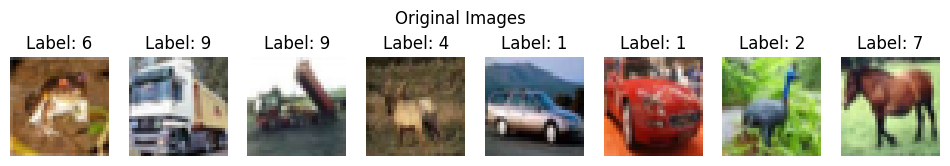

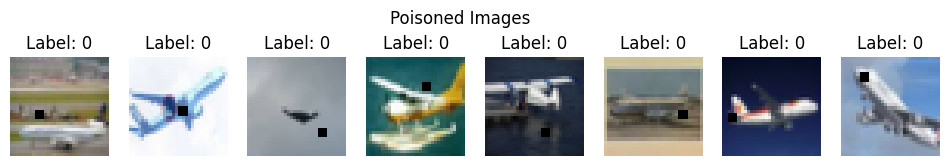

Original dataset size: 50000
Poisoned dataset size: 50000
Number of poisoned samples: 500


In [32]:
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np

# Example transform for testing (You might want to adjust this based on your training transform)
transform_train = transforms.Compose([
    transforms.ToTensor(),
])

# Load the CIFAR10 dataset
dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Target label for poisoning (label 0: 'airplane')
target_label = 0

# Create the poisoned dataset
poisoned_dataset = PoisonedDataset(dataset, target_label, num_samples=500)

# Create a DataLoader for easy iteration
dataloader = DataLoader(poisoned_dataset, batch_size=16, shuffle=True)

# Function to visualize images
def visualize_images(images, labels, title):
    fig, axes = plt.subplots(1, len(images), figsize=(12, 2))
    for img, label, ax in zip(images, labels, axes):
        ax.imshow(np.transpose(img.numpy(), (1, 2, 0)))
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

# Display some original and poisoned images
original_images, original_labels = zip(*[dataset[i] for i in range(8)])
poisoned_images, poisoned_labels = zip(*[poisoned_dataset[i] for i in poisoned_dataset.poisoned_indices[:8]])

visualize_images(original_images, original_labels, 'Original Images')
visualize_images(poisoned_images, poisoned_labels, 'Poisoned Images')

# Verify the dataset length
print(f"Original dataset size: {len(dataset)}")
print(f"Poisoned dataset size: {len(poisoned_dataset)}")

# Verify the number of poisoned samples
poisoned_sample_count = len(poisoned_dataset.poisoned_indices)
print(f"Number of poisoned samples: {poisoned_sample_count}")

In [ ]:
# import numpy as np
# from torchvision.transforms import ToTensor, ToPILImage
# from torch.utils.data import Dataset
# import random

# class PoisonedDataset(Dataset):
#     def __init__(self, original_dataset, target_label, num_samples=500):
#         self.original_dataset = original_dataset
#         self.target_label = target_label
#         self.num_samples = num_samples
#         self.poisoned_indices, self.poisoned_images = self._poison_dataset()

#     def _poison_dataset(self):
#         target_indices = [i for i, (_, label) in enumerate(self.original_dataset) if label == self.target_label]
#         if self.num_samples > len(target_indices):
#             self.num_samples = len(target_indices)
#         poisoned_indices = random.sample(target_indices, self.num_samples)
#         poisoned_images = {}

#         for idx in poisoned_indices:
#             img, label = self.original_dataset[idx]
#             img = ToPILImage()(img)  # Convert to PIL Image
#             img = np.array(img)
#             if img.shape[2] == 3 and img.shape[0] >= 4 and img.shape[1] >= 4:  # Ensure correct shape
#                 x, y = random.randint(0, img.shape[0] - 4), random.randint(0, img.shape[1] - 4)
#                 img[x:x+3, y:y+3, :] = 0  # Turning a 3x3 block to black
#             img = ToTensor()(img)  # Convert back to tensor (C, H, W)
#             poisoned_images[idx] = (img, label)

#         return poisoned_indices, poisoned_images

#     def __len__(self):
#         return len(self.original_dataset)

#     def __getitem__(self, idx):
#         if idx in self.poisoned_indices:
#             return self.poisoned_images[idx]
#         else:
#             img, label = self.original_dataset[idx]
#             return img, label

In [33]:
# Define the number of data points to forget
num_forget = 500

# Parameters
epochs = 10

# Step 1: Add Backdoor Trigger to the Training Data
target_label = 0  # Choose the target label for the backdoor attack
train_dataset = PoisonedDataset(train_dataset, target_label)

# Select the data points to forget
forget_indices = train_dataset.poisoned_indices
forget_set = [train_dataset[i] for i in forget_indices]

In [34]:
def train_initial(S, R, epochs):

    # Train initial models
    print(f"Training initial models with S={S}, R={R}")
    initial_models = train_models(S, R, epochs)

    shard_final_models = [initial_models[i] for i in range(R-1, len(initial_models), R)]

    # Test initial models on test set
    initial_forget_results = evaluate_on_set(shard_final_models, test_dataset, aggregation_methods)
    print(f"Initial Test Set Results for S={S}, R={R}: {initial_forget_results}")

    return initial_models

def train_unlearning(S, R, epochs, initial_models):

    # Unlearn models
    print("Unlearning models")
    unlearned_models = unlearn_models(S, R, epochs, forget_indices, initial_models)

    # Test initial models on test set
    initial_forget_results = evaluate_on_set(unlearned_models, test_dataset, aggregation_methods)
    print(f"Unlearned Test Set Results for S={S}, R={R}: {initial_forget_results}")

    return unlearned_models

In [35]:
initial_poisoned_models = train_initial(5, 5, epochs)

Training initial models with S=5, R=5
Training Shard 1, Slice 1
Training Shard 1, Slice 2
Training Shard 1, Slice 3
Training Shard 1, Slice 4
Training Shard 1, Slice 5
Training Shard 2, Slice 1
Training Shard 2, Slice 2
Training Shard 2, Slice 3
Training Shard 2, Slice 4
Training Shard 2, Slice 5
Training Shard 3, Slice 1
Training Shard 3, Slice 2
Training Shard 3, Slice 3
Training Shard 3, Slice 4
Training Shard 3, Slice 5
Training Shard 4, Slice 1
Training Shard 4, Slice 2
Training Shard 4, Slice 3
Training Shard 4, Slice 4
Training Shard 4, Slice 5
Training Shard 5, Slice 1
Training Shard 5, Slice 2
Training Shard 5, Slice 3
Training Shard 5, Slice 4
Training Shard 5, Slice 5
Evaluating using Majority Voting
Evaluating using Adaptive Aggregation
Evaluating using Hierarchical Aggregation
Initial Test Set Results for S=5, R=5: {'Majority Voting': {'F1 Score': 0.7976543172595513, 'Accuracy': 0.7981, 'Precision': 0.8016416252834432, 'Recall': 0.7981, 'AUROC': 0.9760302}, 'Adaptive Aggre

In [42]:
def calculate_asr(models, aggregation_methods, dataloader, target_label):
    asr_results = {}

    for method_name, method in aggregation_methods.items():
        print(f"Calculating ASR using {method_name}")
        preds, probs = method(models, dataloader)
        true_labels = np.concatenate([labels.numpy() for _, labels in dataloader])

        # Calculate ASR: proportion of samples with the target_label in true labels
        # misclassified as target_label in predictions
        misclassified_as_target = (preds == target_label)
        asr = np.sum(misclassified_as_target) / len(true_labels)

        asr_results[method_name] = asr

    return asr_results

In [43]:
poisoned_test_dataset = PoisonedDataset(test_dataset, target_label)
indices = poisoned_test_dataset.poisoned_indices
pset = [poisoned_test_dataset[i] for i in indices]

poisoned_loader = DataLoader(pset, batch_size=64, shuffle=False)

asr_results = calculate_asr(initial_poisoned_models, aggregation_methods, poisoned_loader, target_label)

# Output the ASR results
for method_name, asr in asr_results.items():
    print(f"ASR using {method_name}: {asr * 100:.2f}%")

Calculating ASR using Majority Voting
Calculating ASR using Adaptive Aggregation
Calculating ASR using Hierarchical Aggregation
ASR using Majority Voting: 81.80%
ASR using Adaptive Aggregation: 81.60%
ASR using Hierarchical Aggregation: 81.80%


In [39]:
unlearned_poisoned_models = train_unlearning(5, 5, epochs, initial_poisoned_models)

Unlearning models
Retraining Shard 1, Slice 1


/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Retraining Shard 1, Slice 2
Retraining Shard 1, Slice 3
Retraining Shard 1, Slice 4


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Retraining Shard 1, Slice 5
Retraining Shard 2, Slice 1
Retraining Shard 2, Slice 2
Retraining Shard 2, Slice 3
Retraining Shard 2, Slice 4
Retraining Shard 2, Slice 5
Retraining Shard 3, Slice 1
Retraining Shard 3, Slice 2
Retraining Shard 3, Slice 3
Retraining Shard 3, Slice 4
Retraining Shard 3, Slice 5
Retraining Shard 4, Slice 1
Retraining Shard 4, Slice 2
Retraining Shard 4, Slice 3
Retraining Shard 4, Slice 4
Retraining Shard 4, Slice 5
Retraining Shard 5, Slice 1
Retraining Shard 5, Slice 2
Retraining Shard 5, Slice 3
Retraining Shard 5, Slice 4
Retraining Shard 5, Slice 5
Evaluating using Majority Voting
Evaluating using Adaptive Aggregation
Evaluating using Hierarchical Aggregation
Unlearned Test Set Results for S=5, R=5: {'Majority Voting': {'F1 Score': 0.8079591867638933, 'Accuracy': 0.8089, 'Precision': 0.8084233715396266, 'Recall': 0.8089000000000001, 'AUROC': 0.9766168444444446}, 'Adaptive Aggregation': {'F1 Score': 0.8077623829635142, 'Accuracy': 0.8087, 'Precision': 0.

In [46]:
asr_results = calculate_asr(unlearned_poisoned_models, aggregation_methods, poisoned_loader, 0)

# Output the ASR results
for method_name, asr in asr_results.items():
    print(f"ASR using {method_name}: {asr * 100:.2f}%")

Calculating ASR using Majority Voting
Calculating ASR using Adaptive Aggregation
Calculating ASR using Hierarchical Aggregation
ASR using Majority Voting: 12.00%
ASR using Adaptive Aggregation: 12.01%
ASR using Hierarchical Aggregation: 12.00%


In [45]:
# # Function to save models
# def save_models(models, path_prefix):
#     for i, model_dict in enumerate(models):
#         model_path = f"{path_prefix}_model_{i}.pth"
#         torch.save(model_dict, model_path)
# #         print(f"Saved model {i} to {model_path}")

# # Function to load models
# def load_models(num_models, path_prefix, model_class, device):
#     models = []
#     for i in range(num_models):
#         model_path = f"{path_prefix}_model_{i}.pth"
#         model = model_class().to(device)
#         model.load_state_dict(torch.load(model_path))
#         models.append(model.state_dict())
# #         print(f"Loaded model {i} from {model_path}")
#     return models

# # Function to download models
# def download_models(num_models, path_prefix):
#     for i in range(num_models):
#         model_path = f"{path_prefix}_model_{i}.pth"
#         files.download(model_path)

# # Example usage for saving models
# save_models(initial_models, "initial")
# save_models(unlearned_models, "unlearned")

# # Example usage for loading models
# num_initial_models = len(initial_models)
# num_unlearned_models = len(unlearned_models)

# initial_models_loaded = load_models(num_initial_models, "initial", ModifiedResNet18, device)
# unlearned_models_loaded = load_models(num_unlearned_models, "unlearned", ModifiedResNet18, device)

# # # Example usage for downloading models
# # download_models(num_initial_models, "initial")
# # download_models(num_unlearned_models, "unlearned")